#### Importing dependancies

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import datetime
from textblob import TextBlob
import requests 
from bs4 import BeautifulSoup
# from sys import
import warnings
warnings.filterwarnings("ignore")

In [52]:
def scrape_yahoo(search_term, till_page):
    pn = 1
    l = []
    t = []

    for lkd in range(till_page):
        url = "https://news.search.yahoo.com/search?q={}&pz=10&b={}".format(search_term, pn)
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        headlines = soup.find_all("div")

        d = []
        for h in headlines:
            d.append(TextBlob(h.get_text()))


        for i in range(len(d[0].split("...")[:-1])):
            try:
                ind = [[i.start(),i.end()] for i in re.finditer(re.compile("|".join(["\d+\s*(?:year|years)\s*ago",
                                                                                     "\d+\s*(?:day|days)\s*ago",
                                                                                     "\d+\s*(?:hour|hours)\s*ago",
                                                                                     "\d+\s*(?:minute|minute)\s*ago",
                                                                                     "\d+\s*(?:seconds|seconds)\s*ago",
                                                                                     "Local\s*Answers\s*Shopping\s*More"])), 
                                                                d[0].split("...")[i])]
                timings = re.findall(re.compile("|".join(["\d+\s*(?:year|years)\s*ago",
                                                          "\d+\s*(?:day|days)\s*ago",
                                                          "\d+\s*(?:hour|hours)\s*ago",
                                                          "\d+\s*(?:minute|minute)\s*ago",
                                                          "\d+\s*(?:seconds|seconds)\s*ago"])), 
                                                                d[0].split("...")[i])
                if i==0:
                    l.append((d[0].split("...")[i][ind[0][1] : ind[1][0]], timings[0]))
    #                 t.append(timings[0])
                else:
                    l.append((d[0].split("...")[i][:ind[0][0]], timings[0]))
    #                 t.append(timings[0])
            except:
                pass

        pn = pn + 10
        
        
    df = pd.DataFrame(l, columns=["News","Timing"])

    df["Date_Time"] = np.nan
    for i in range(len(df["Timing"])):
        if "day" in df["Timing"][i]:
            df["Date_Time"][i] = datetime.datetime.now()-datetime.timedelta(days=int(re.findall(re.compile("(\d+)"),
                                                                                         df["Timing"][i])[0]))
        elif "hour" in df["Timing"][i]:
            df["Date_Time"][i] = datetime.datetime.now()-datetime.timedelta(hours=int(re.findall(re.compile("(\d+)"),
                                                                                          df["Timing"][i])[0]))

    df["Date_Time"] = pd.to_datetime(df["Date_Time"].dt.date)
    df = df.sort_values(by=["Date_Time"], ascending=False).reset_index(drop=True)
    vader = SentimentIntensityAnalyzer()
    df["Compounded_Polarity"] = [vader.polarity_scores(k)["compound"] for k in df["News"]]
    
    
    
    df = df.drop_duplicates().reset_index(drop=True)
    df = df[df.index.isin([i for i in range(len(df["News"])) if len(df["News"][i].split(" "))>5])].reset_index(drop=True)
    df = df.sort_values(by=["Date_Time"], ascending=False).reset_index(drop=True)
    return df

In [76]:
df = scrape_yahoo("GE stock", 20)

In [77]:
df

,News,Timing,Date_Time,Compounded_Polarity
0,"When It Comes to Power Generation, Buy Bloom ...",11 hours ago,2020-11-12,0.0000
1,3-D Printing Is Graduating to the Factory Flo...,6 hours ago,2020-11-12,0.3400
2,GE Ends Century-Old Development Programcitybi...,16 hours ago,2020-11-12,0.0000
3,Greener pastures: Bitcoin miners now looking ...,9 hours ago,2020-11-12,0.0000
4,"Top Stock Reports for Coca-Cola, Merck & Hone...",3 hours ago,2020-11-12,0.2023
5,How a Veteran Bond Manager Finds Pockets of O...,1 day ago,2020-11-11,0.0000
6,5 Reasons Why Danaher (DHR) Stock is Worth In...,1 day ago,2020-11-11,0.2263
7,"The Top 5 ""Millionaire-Maker"" Long-Term Stock...",1 day ago,2020-11-11,0.2023
8,Whirlpool: Strong Margin Growth And FCF Gener...,1 day ago,2020-11-11,0.7096
9,General Electric: The Road To Junk Status Resu...,1 day ago,2020-11-11,0.0000


<BarContainer object of 8 artists>

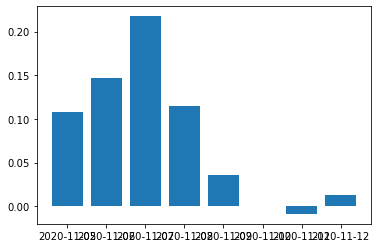

In [78]:
plt.bar(df["Date_Time"].unique(),df.groupby(["Date_Time"])["Compounded_Polarity"].mean())